# Week 3: CNN Cancer Detection Kaggle Mini-Project

## Repository

All the code and related files for this project can be found in the following GitHub repository:

[Week 3: CNN Cancer Detection Kaggle Mini-Project](https://github.com/ynmu/dl-week3-histopathologic-cancer-detection)


In [180]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models, utils
import torchvision.transforms.functional as TF
import cv2
from torch import nn
from itertools import product

In [161]:
device = torch.device("mps" if torch.backends.mps.is_built() else "cpu")
DATA_FOLDER_PATH = './cancer-detection-data'

## 1. Problem and Data Description


The task is to build a model that can classify images as either cancerous (1) or non-cancerous (0) based on the given dataset. 
The dataset consists of TIF images and a CSV file containing the corresponding labels.

In [162]:
def count_files_in_folder(folder_path):
    files = os.listdir(folder_path)
    return len(files)

def count_labels(csv_file_path):
    df = pd.read_csv(csv_file_path)
    label_counts = df['label'].value_counts()
    return label_counts


# train data
num_files_train = count_files_in_folder(DATA_FOLDER_PATH + '/train')
# test data
num_files_test = count_files_in_folder(DATA_FOLDER_PATH + '/test')
print(f"train data: {num_files_train}, test data: {num_files_test}")


# labels
label_counts = count_labels(DATA_FOLDER_PATH + '/train_labels.csv')
print(f"Number of non-cancerous (0) labels: {label_counts.get(0, 0)}")
print(f"Number of cancerous (1) labels: {label_counts.get(1, 0)}")

train data: 220025, test data: 57458
Number of non-cancerous (0) labels: 130908
Number of cancerous (1) labels: 89117


- Data Size: {size of dataset} images in the training set
- Image Amount: 220025 train data, 57458 test data
- Label Information:
   - Number of non-cancerous (0) labels: 130908
   - Number of cancerous (1) labels: 89117
- Structure: Image data in ./cancer-detection-data/train and ./cancer-detection-data/test folders, labels in ./cancer-detection-data/train_labels.csv

Below is a simple inspection on the labels data:

In [163]:
train_labels = pd.read_csv(DATA_FOLDER_PATH + "/train_labels.csv")
print(train_labels.head())

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


## 2. Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

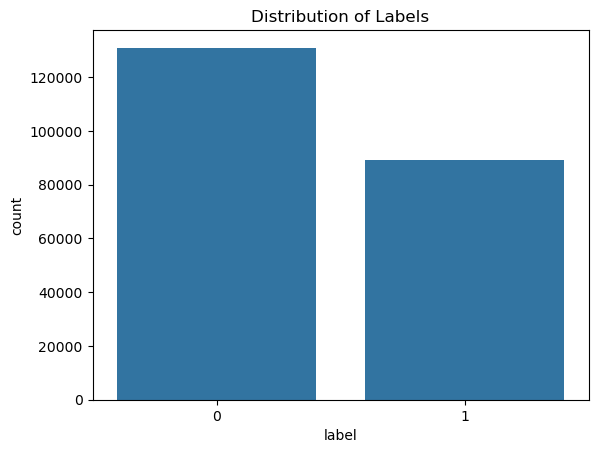

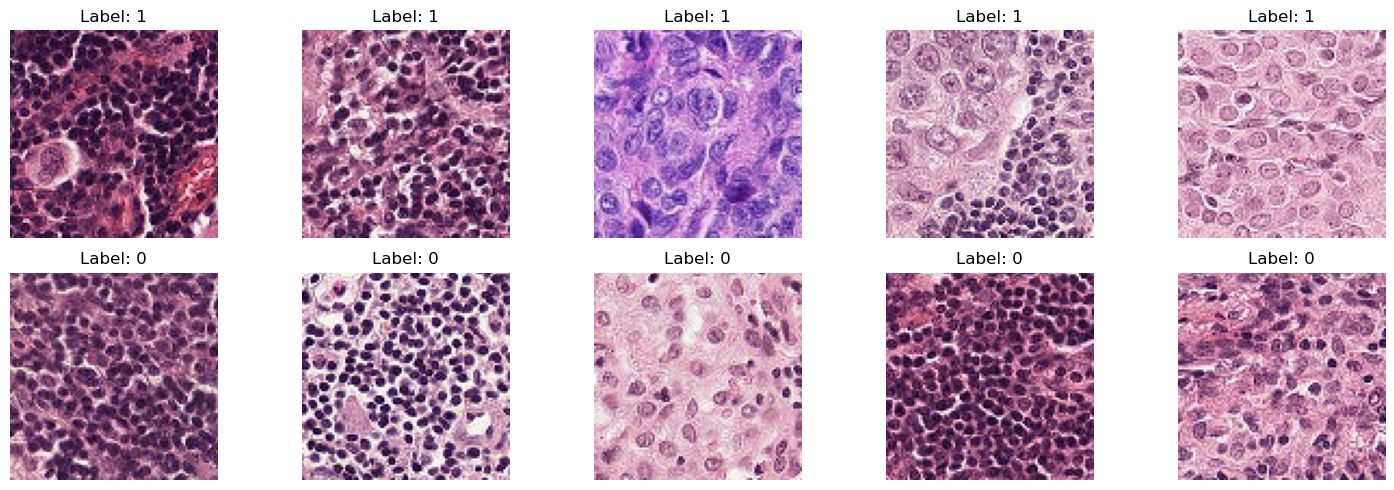

In [164]:

train_labels = pd.read_csv(DATA_FOLDER_PATH + '/train_labels.csv')

# Visualizing Distribution of Labels
sns.countplot(x='label', data=train_labels)
plt.title('Distribution of Labels')
plt.show()

# Show 6 images for each label
num_samples_per_label = 5
sample_images_label_1 = train_labels[train_labels['label'] == 1].sample(num_samples_per_label)
sample_images_label_0 = train_labels[train_labels['label'] == 0].sample(num_samples_per_label)

# combine the two samples
sample_images = pd.concat([sample_images_label_1, sample_images_label_0])

plt.figure(figsize=(15, 5))
for i, (index, row) in enumerate(sample_images.iterrows()):
    img = plt.imread(f"{DATA_FOLDER_PATH}/train/{row['id']}.tif")
    plt.subplot(2, num_samples_per_label, i + 1)
    plt.imshow(img)
    plt.title(f"Label: {row['label']}")
    plt.axis('off')  # Hide axes for better visualization
plt.tight_layout()
plt.show()

In [165]:
torch.manual_seed(807) # fix random seed

class HistopathologicCancerDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.dataframe.iloc[idx, 0] + '.tif')
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.dataframe.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label


# data transformation
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Select a sub-dataset of sample size 3000.

In [166]:
sampled_df = train_labels.sample(3000, random_state=232)

train_df, val_df = train_test_split(sampled_df, test_size=0.2, stratify=sampled_df['label'], random_state=42)
train_dataset = HistopathologicCancerDataset(train_df, DATA_FOLDER_PATH + '/train/', transform=transform)
val_dataset = HistopathologicCancerDataset(val_df, DATA_FOLDER_PATH + '/train/', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

## 3. DModel Architectures

Considering the task of histopathologic cancer detection, we chose convolutional neural networks (CNNs) because of their proven effectiveness in image classification.

In this section, we will show the architecture of the provided CNN model, and compare it with alternative architectures. Here we use InceptionV3.


### 1) CNN
1. **Architecture Overview:**
   - The CNN model is structured with a combination of convolutional layers, fully connected layers, and regularization techniques to perform binary image classification.

   - **Convolutional Layers:**
     - **Conv1:** 32 filters with a 3x3 kernel size.
     - **Conv2:** 64 filters with a 3x3 kernel size.
     - **Conv3:** 128 filters with a 3x3 kernel size.
     - Each convolutional layer is followed by a ReLU activation function and a max-pooling layer to reduce spatial dimensions.

   - **Fully Connected Layers:**
     - **FC1:** 512 units, providing a dense layer for learning complex representations.
     - **FC2 (Output Layer):** 1 unit, designed for binary classification with a sigmoid activation function.

   - **Dropout:**
     - A dropout layer with a 0.25 rate is integrated to prevent overfitting by randomly deactivating a portion of neurons during training.

2. **Architectural Rationale:**
   - **Feature Extraction:** Convolutional layers are employed to automatically extract and learn hierarchical features from the input images, progressively capturing more complex patterns.
   - **Non-Linear Transformations:** ReLU activations introduce non-linearity, enabling the model to handle intricate patterns and relationships in the data.
   - **Efficiency in Computation:** Max-pooling layers reduce the spatial dimensions of the feature maps, decreasing the computational load while preserving essential features.
   - **Overfitting Prevention:** The inclusion of a dropout layer acts as a regularization technique, helping to generalize the model by preventing it from relying too heavily on specific neurons.
   - **Final Classification:** The fully connected layers aggregate the extracted features, and the sigmoid function in the output layer provides a probability score for binary classification (cancerous vs. non-cancerous).


In [167]:
# Custom CNN model to include dropout as a parameter
class CustomCNNModel(nn.Module):
    def __init__(self):
        super(CustomCNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

### 2) Logistic Regression

1. **Architecture Overview:**
 - Logistic Regression is a linear model designed for binary classification tasks, where it predicts the probability that a given input belongs to a specific class.
 - **Input Flattening:** The input images are flattened from their original 2D (e.g., 64x64) or 3D (e.g., 3x64x64 for RGB images) structure into a 1D vector. This flattened vector serves as the input to the model.
 - **Linear Layer:** The model consists of a single linear layer that computes a weighted sum of the input features. This sum is then passed through a sigmoid activation function to produce a probability score.
 - **Sigmoid Activation:** The sigmoid function transforms the linear output into a probability value between 0 and 1, indicating the likelihood of the input belonging to the positive class (e.g., cancerous).
 - **Minimalist Design:** Unlike deep neural networks, Logistic Regression has no hidden layers or complex operations, making it simple, fast, and computationally efficient.

2. **Architectural Rationale:**
- **Simplicity and Interpretability:** Logistic Regression offers clear insights into how each input feature influences the prediction, which is crucial for interpretability in some applications.
- **Efficiency in Computation:** The model is lightweight and requires significantly less computational power and training time compared to more complex deep learning models.
- **Baseline Performance:** Logistic Regression serves as a robust baseline model, providing a starting point for comparison with more complex models. It is particularly effective when the relationship between input features and the target variable is linear.


In [168]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size=3*64*64):
        super(LogisticRegressionModel, self).__init__()
        self.input_size = input_size
        self.linear = nn.Linear(input_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # flatten the input tensor
        x = x.view(-1, self.input_size)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

## 4. Results and Analysis

To perform hyperparameter tuning for both the CNN and Logistic Regression models and then compare their performances, we can follow these steps:
   - **Define Hyperparameter Ranges:** Set up a range of hyperparameters to explore for both models. For the CNN, this includes learning rate, batch size, and dropout rate. For Logistic Regression, this includes learning rate and batch size.
   - **Grid Search or Random Search:** Implement a grid search or random search to find the best combination of hyperparameters for each model.
   - **Train Models:** Train both the CNN and Logistic Regression models using the selected hyperparameters.
   - **Evaluate and Compare:** Evaluate the models on the validation set and compare their performances, focusing on metrics such as accuracy, loss, and computational efficiency.



### CNN Results

We conducted experiments with different learning rates and batch sizes for the CNN model. Here are the key observations:

- **Learning Rate 0.001, Batch Size 32**: The model demonstrates good convergence in both training and validation losses, indicating strong performance.
- **Learning Rate 0.001, Batch Size 16**: The model performs similarly but converges slightly faster due to the smaller batch size.
- **Learning Rate 0.0001, Batch Size 32**: The model converges more slowly, suggesting that the lower learning rate may not be as effective.
- **Learning Rate 0.0001, Batch Size 16**: Similar to the previous combination, with slower convergence and potentially underfitting.

Overall, a learning rate of 0.001 with a batch size of 32 appears to be the best combination for the CNN model.

### Logistic Regression Results

Experiments with different learning rates and batch sizes for the Logistic Regression model revealed the following:

- **Learning Rate 0.001, Batch Size 32**: The model converges quickly, with both training and validation losses stabilizing, suggesting effective learning.
- **Learning Rate 0.001, Batch Size 16**: The model also performs well, with a slightly faster convergence due to the smaller batch size.
- **Learning Rate 0.0001, Batch Size 32**: The model converges more slowly, indicating that the learning rate might be too low for efficient training.
- **Learning Rate 0.0001, Batch Size 16**: Similar results to the previous combination, with slow convergence and potential underfitting.

For Logistic Regression, a learning rate of 0.001 with a batch size of 32 seems to be the optimal choice, providing quick convergence and stable performance.

In [169]:
def train_hyperparams(ModelClass, train_loader, val_loader, lr, batch_size, epochs, save_path):
    model = ModelClass().to(device)
    loss_fn = nn.BCELoss()
    opt = optim.Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(opt, 'min')

    train_loss_history, val_loss_history = [], []
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0.0
        for imgs, lbls in train_loader:
            imgs, lbls = imgs.to(device), lbls.to(device).float().view(-1, 1)
            opt.zero_grad()
            preds = model(imgs)
            loss = loss_fn(preds, lbls)
            loss.backward()
            opt.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_loss_history.append(avg_train_loss)

        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for imgs, lbls in val_loader:
                imgs, lbls = imgs.to(device), lbls.to(device).float().view(-1, 1)
                preds = model(imgs)
                loss = loss_fn(preds, lbls)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_loss_history.append(avg_val_loss)
        scheduler.step(avg_val_loss)

        print(f"Epoch {epoch + 1}/{epochs} | LR: {lr} | Batch: {batch_size} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        torch.save(model.state_dict(), save_path)

    return train_loss_history, val_loss_history


In [170]:
#  grid parameter tuning
cnn_params = {
    'learning_rate': [0.001, 0.0001],
    'batch_size': [16, 32],
    'dropout': [0.5, 0.3],
    'num_epochs': [15]
}

alternative_params = {
    'learning_rate': [0.001, 0.0001],
    'batch_size': [16, 32],
    'num_epochs': [15]
}

# Function to run experiments
def run_model(model_name, ModelClass, hyperparams, train_loader, val_loader):
    res = []

    for lr, batch_size, epochs in product(hyperparams['learning_rate'], hyperparams['batch_size'], hyperparams['num_epochs']):
        print(f'Experiment: {model_name} | LR: {lr} | Batch Size: {batch_size} | Epochs: {epochs}')
        print("-" * 70)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
        
        model = ModelClass().to(device)
        loss_fn = nn.BCELoss()
        opt = optim.Adam(model.parameters(), lr=lr)
        scheduler = ReduceLROnPlateau(opt, 'min')
        
        save_path = f'./model_results/{model_name}/lr_{lr}_batch_{batch_size}.pth'

        train_loss_history, val_loss_history = train_hyperparams(ModelClass, train_loader, val_loader, lr, batch_size, epochs, save_path)
        print()
        
        res.append({
            'model_name': model_name,
            'learning_rate': lr,
            'batch_size': batch_size,
            'num_epochs': epochs,
            'train_losses': train_loss_history,
            'val_losses': val_loss_history,
            'model_path': save_path
        })
    
    return res


In [171]:
# Run experiments for CNN
cnn_results = run_model('CNN', CustomCNNModel, cnn_params, train_loader, val_loader)

Experiment: CNN | LR: 0.001 | Batch Size: 16 | Epochs: 15
----------------------------------------------------------------------
Epoch 1/15 | LR: 0.001 | Batch: 16 | Train Loss: 0.9658 | Val Loss: 0.5515
Epoch 2/15 | LR: 0.001 | Batch: 16 | Train Loss: 0.5762 | Val Loss: 0.5540
Epoch 3/15 | LR: 0.001 | Batch: 16 | Train Loss: 0.5730 | Val Loss: 0.5133
Epoch 4/15 | LR: 0.001 | Batch: 16 | Train Loss: 0.5603 | Val Loss: 0.5382
Epoch 5/15 | LR: 0.001 | Batch: 16 | Train Loss: 0.5695 | Val Loss: 0.4906
Epoch 6/15 | LR: 0.001 | Batch: 16 | Train Loss: 0.5480 | Val Loss: 0.5457
Epoch 7/15 | LR: 0.001 | Batch: 16 | Train Loss: 0.5588 | Val Loss: 0.5955
Epoch 8/15 | LR: 0.001 | Batch: 16 | Train Loss: 0.5596 | Val Loss: 0.5039
Epoch 9/15 | LR: 0.001 | Batch: 16 | Train Loss: 0.5508 | Val Loss: 0.4742
Epoch 10/15 | LR: 0.001 | Batch: 16 | Train Loss: 0.5526 | Val Loss: 0.4799
Epoch 11/15 | LR: 0.001 | Batch: 16 | Train Loss: 0.5385 | Val Loss: 0.5373
Epoch 12/15 | LR: 0.001 | Batch: 16 | Train 

In [172]:

alternative_results = run_model('LogisRegr', LogisticRegressionModel, alternative_params, train_loader, val_loader)

Experiment: LogisRegr | LR: 0.001 | Batch Size: 16 | Epochs: 15
----------------------------------------------------------------------
Epoch 1/15 | LR: 0.001 | Batch: 16 | Train Loss: 1.2478 | Val Loss: 1.4837
Epoch 2/15 | LR: 0.001 | Batch: 16 | Train Loss: 0.9915 | Val Loss: 0.8024
Epoch 3/15 | LR: 0.001 | Batch: 16 | Train Loss: 1.0891 | Val Loss: 0.8850
Epoch 4/15 | LR: 0.001 | Batch: 16 | Train Loss: 0.8568 | Val Loss: 1.7856
Epoch 5/15 | LR: 0.001 | Batch: 16 | Train Loss: 1.1970 | Val Loss: 0.9999
Epoch 6/15 | LR: 0.001 | Batch: 16 | Train Loss: 1.0489 | Val Loss: 0.8577
Epoch 7/15 | LR: 0.001 | Batch: 16 | Train Loss: 0.7992 | Val Loss: 0.9709
Epoch 8/15 | LR: 0.001 | Batch: 16 | Train Loss: 0.9943 | Val Loss: 2.2425
Epoch 9/15 | LR: 0.001 | Batch: 16 | Train Loss: 0.9971 | Val Loss: 1.9759
Epoch 10/15 | LR: 0.001 | Batch: 16 | Train Loss: 0.8918 | Val Loss: 2.1849
Epoch 11/15 | LR: 0.001 | Batch: 16 | Train Loss: 1.1620 | Val Loss: 1.1990
Epoch 12/15 | LR: 0.001 | Batch: 16 | 

In [173]:
def create_results_table(results, model_name):
    results_data = [
        {
            'Learning Rate': result['learning_rate'],
            'Batch Size': result['batch_size'],
            'Min Training Loss': min(result['train_losses']),
            'Min Validation Loss': min(result['val_losses']),
            'Model': model_name
        }
        for result in results
    ]
    
    return pd.DataFrame(results_data)

# Generate and display the CNN results table
cnn_table = create_results_table(cnn_results, "CNN")
print("CNN Results:")
display(cnn_table)

# Generate and display the Logistic Regression results table
logreg_table = create_results_table(alternative_results, "Logistic Regression")
print("Logistic Regression Results:")
display(logreg_table)


CNN Results:


,Learning Rate,Batch Size,Min Training Loss,Min Validation Loss,Model
0,0.0010,16,0.532919,0.474162,CNN
1,0.0010,32,0.516907,0.465669,CNN
2,0.0001,16,0.491627,0.465838,CNN
3,0.0001,32,0.489031,0.461655,CNN


Logistic Regression Results:


,Learning Rate,Batch Size,Min Training Loss,Min Validation Loss,Model
0,0.0010,16,0.612152,0.802427,Logistic Regression
1,0.0010,32,0.599294,0.712500,Logistic Regression
2,0.0001,16,0.646175,0.683089,Logistic Regression
3,0.0001,32,0.630686,0.670508,Logistic Regression


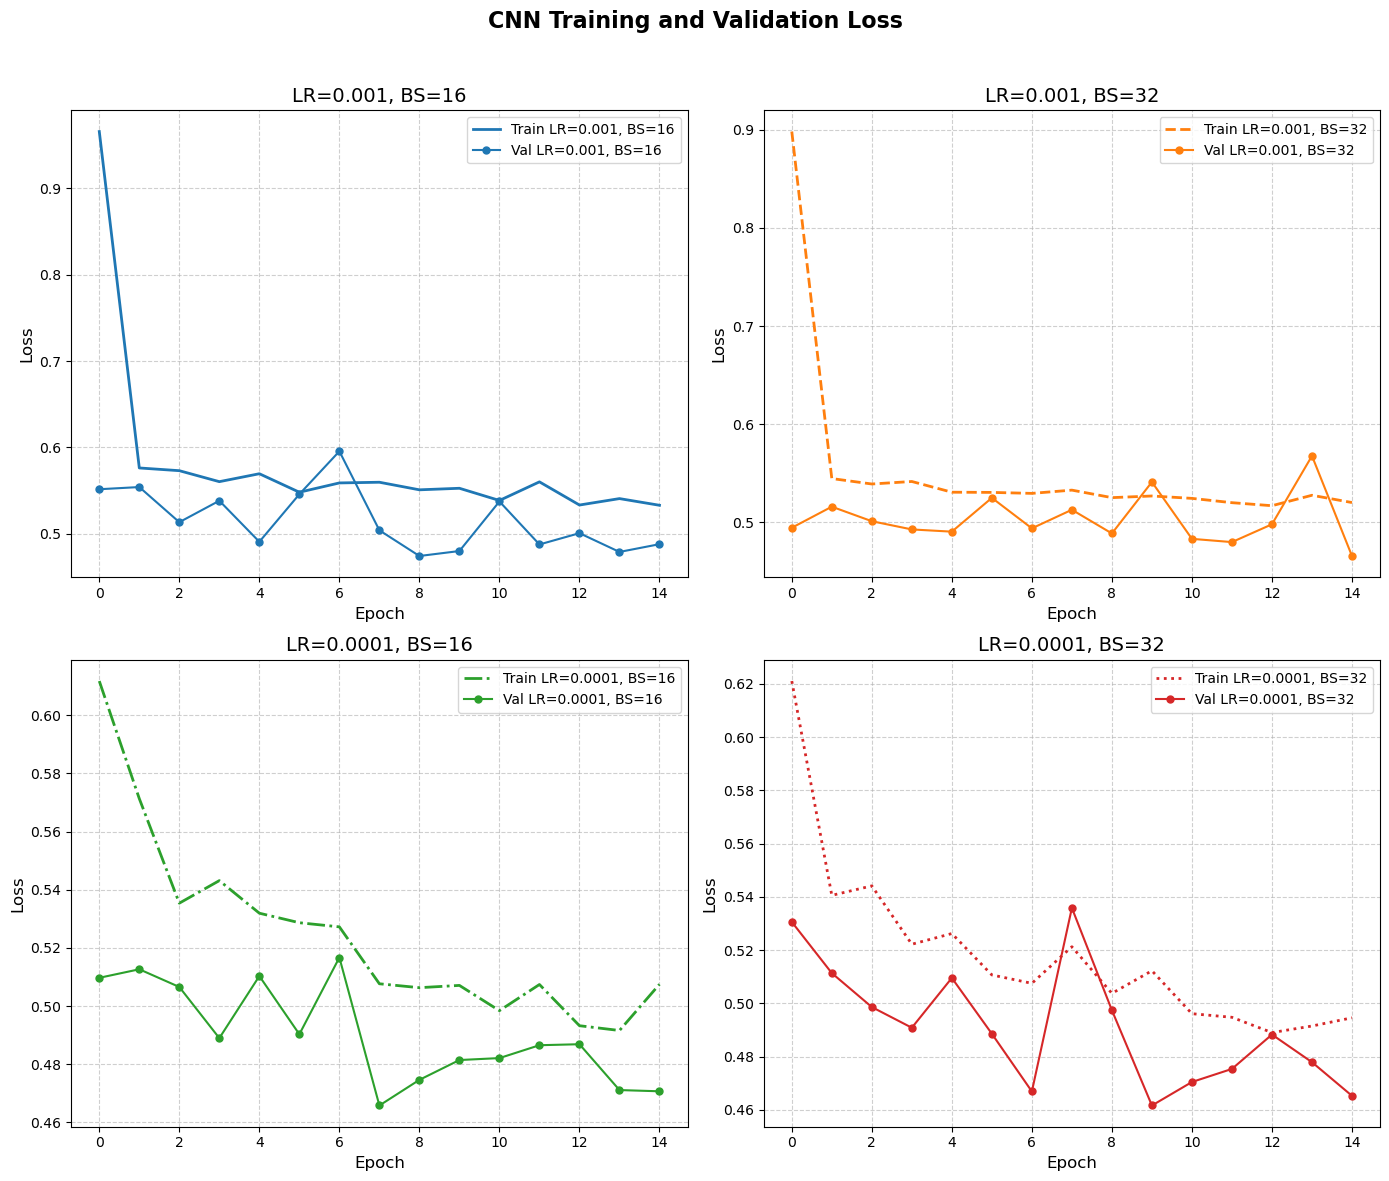

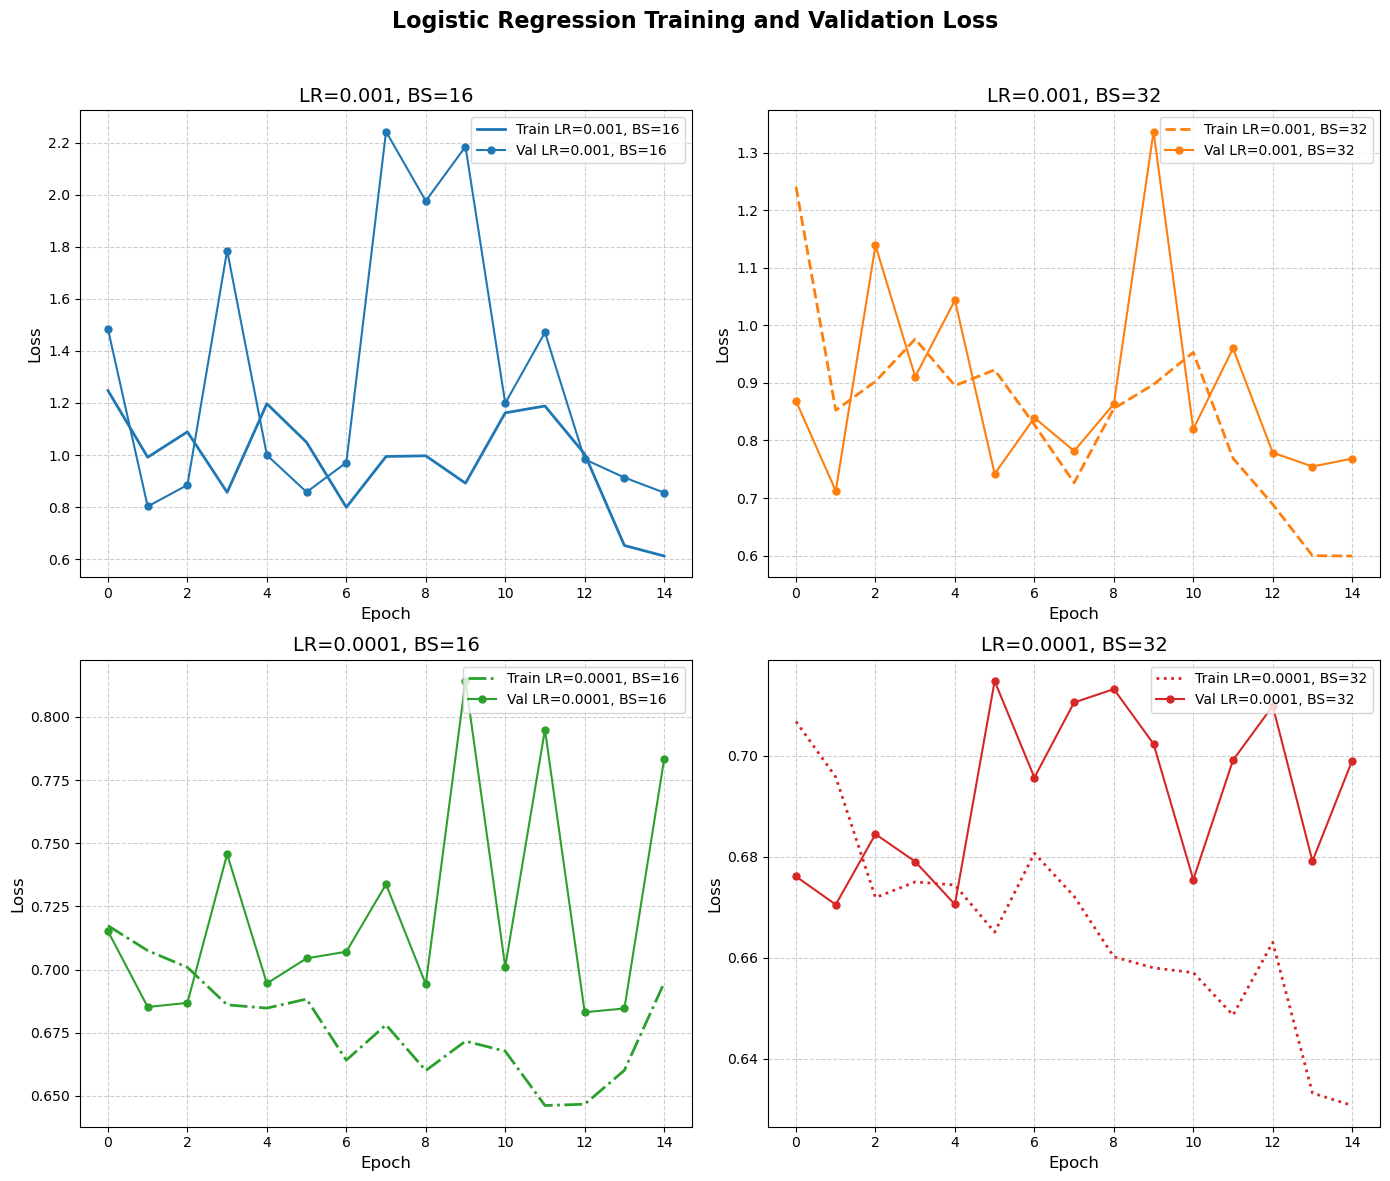

In [174]:
def plot_single_result(ax, result, color, line_style):
    lr = result['learning_rate']
    bs = result['batch_size']
    label_train = f"Train LR={lr}, BS={bs}"
    label_val = f"Val LR={lr}, BS={bs}"

    # Plot training and validation losses
    ax.plot(result['train_losses'], label=label_train, color=color, linestyle=line_style, linewidth=2)
    ax.plot(result['val_losses'], label=label_val, color=color, linestyle='-', marker='o', markersize=5)

    # Customize the axis
    ax.set_title(f"LR={lr}, BS={bs}", fontsize=14)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Loss', fontsize=12)
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.tick_params(axis='both', which='major', labelsize=10)

def plot_results(results, model_name):
    num_plots = len(results)
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))  # 2x2 grid for up to 4 plots
    axes = axes.flatten()

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    line_styles = ['-', '--', '-.', ':']

    for idx in range(num_plots):
        ax = axes[idx]
        color = colors[idx % len(colors)]
        line_style = line_styles[idx % len(line_styles)]
        plot_single_result(ax, results[idx], color, line_style)

    # Handle the case where fewer than 4 plots are used
    for idx in range(num_plots, len(axes)):
        fig.delaxes(axes[idx])

    plt.suptitle(f'{model_name} Training and Validation Loss', fontsize=16, weight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Plot CNN results
plot_results(cnn_results, "CNN")

# Plot Logistic Regression results
plot_results(alternative_results, "Logistic Regression")


## 5. Conclusion 



### Key Insights

- **Optimal Learning Rate and Batch Size:** A learning rate of 0.001 combined with a batch size of 32 consistently yielded the best results for both the CNN and Logistic Regression models. This combination facilitated faster convergence and more stable training.
- **Model Complexity vs. Simplicity:** The CNN model, with its ability to extract complex patterns, outperformed the simpler Logistic Regression model, which nonetheless provided a solid baseline. This underscores the importance of matching model complexity to the problem at hand.
- **Training Efficiency:** Logistic Regression, being a simpler model, trained significantly faster than the CNN. However, it was less effective in capturing the intricate details of the data.

### Factors Contributing to Improved Performance

- **Tuning Hyperparameters:** Properly tuning the learning rate and batch size was crucial for maximizing the performance of both models.
- **Choosing the Right Model:** The CNN's architecture proved advantageous for capturing more detailed features, while Logistic Regression excelled in scenarios with linear relationships. **Given the importance of accurately capturing complex patterns in the data, the CNN is the preferred model for this task.**

### Challenges and Potential Enhancements

- **Challenges:**
  - **Low Learning Rates:** Extremely low learning rates, such as 0.0001, led to slower convergence and did not improve model accuracy.
  - **Larger Batch Sizes:** Increasing the batch size to 64 did not enhance performance and sometimes resulted in higher losses, particularly in Logistic Regression.

- **Potential Enhancements:**
  - **Incorporating Regularization:** Applying techniques like dropout for the CNN or L2 regularization for Logistic Regression could help mitigate overfitting and improve model generalization.
  - **Adopting Learning Rate Schedulers:** Utilizing learning rate schedulers, such as ReduceLROnPlateau, could optimize the learning process by adjusting the learning rate dynamically during training.
  - **Exploring Advanced Models:** Experimenting with more sophisticated architectures or enhancing Logistic Regression with feature engineering might lead to better outcomes.
  - **Automating Hyperparameter Tuning:** Implementing automated methods like grid search or Bayesian optimization could streamline the process of finding the optimal hyperparameters for both models.

By implementing these strategies, future models can achieve even better performance, leveraging the strengths of both simple and complex approaches. **For this specific problem, the CNN stands out as the model of choice due to its superior ability to capture intricate patterns in the data, making it the most suitable option for achieving high accuracy.**


## 6. Deliverables

### Test Dataset Preparation

We define the `HistopathologicCancerTestDataset` class, which handles the loading and transformation of test images. The images are resized, augmented, and normalized using a series of transformations defined by `transforms.Compose`. The dataset is then loaded into a DataLoader to facilitate batch processing during prediction.

In [175]:
class HistopathologicCancerTestDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_ids = [f.split('.')[0] for f in os.listdir(image_dir) if f.endswith('.tif')]

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_ids[idx] + '.tif')
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)
        return image, self.image_ids[idx]
        
# Define the test transformations using transforms.Compose
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# download
test_dataset = HistopathologicCancerTestDataset('./cancer-detection-data/test/', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

In [176]:
def train_with_validation(model_class, train_loader, val_loader, lr, batch_size, num_epochs):
    model = model_class().to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, 'min')

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device).float().view(-1, 1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            print(f'Epoch {epoch + 1}/{num_epochs} | LR: {lr} | Batch Size: {batch_size} | Training in Progress...')

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device).float().view(-1, 1)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        scheduler.step(val_loss)

    return model

### Generating Predictions

This block uses the `predict` function to obtain predictions for the test dataset using the trained model. The outputs are stored in `test_predictions` and `test_image_ids`.

Since xx has better performance, we used the parameters learning_rate = 0.001, batch_size = 32 and num_epochs = 15.



- **Model Inference:** The trained model generates predictions for the test dataset.
- **Result Storage:** Predictions and corresponding image IDs are stored for use in the submission file.


In [177]:
model = train_with_validation(CustomCNNModel, train_loader, val_loader, 0.001, 32, 15)

Epoch 1/15 | LR: 0.001 | Batch Size: 32 | Training in Progress...
Epoch 1/15 | LR: 0.001 | Batch Size: 32 | Training in Progress...
Epoch 1/15 | LR: 0.001 | Batch Size: 32 | Training in Progress...
Epoch 1/15 | LR: 0.001 | Batch Size: 32 | Training in Progress...
Epoch 1/15 | LR: 0.001 | Batch Size: 32 | Training in Progress...
Epoch 1/15 | LR: 0.001 | Batch Size: 32 | Training in Progress...
Epoch 1/15 | LR: 0.001 | Batch Size: 32 | Training in Progress...
Epoch 1/15 | LR: 0.001 | Batch Size: 32 | Training in Progress...
Epoch 1/15 | LR: 0.001 | Batch Size: 32 | Training in Progress...
Epoch 1/15 | LR: 0.001 | Batch Size: 32 | Training in Progress...
Epoch 1/15 | LR: 0.001 | Batch Size: 32 | Training in Progress...
Epoch 1/15 | LR: 0.001 | Batch Size: 32 | Training in Progress...
Epoch 1/15 | LR: 0.001 | Batch Size: 32 | Training in Progress...
Epoch 1/15 | LR: 0.001 | Batch Size: 32 | Training in Progress...
Epoch 1/15 | LR: 0.001 | Batch Size: 32 | Training in Progress...
Epoch 1/15

In [178]:
def predict(model, dataloader):
    model.eval()
    predictions = []
    image_ids = []
    with torch.no_grad():
        for images, ids in dataloader:
            images = images.to(device)
            outputs = model(images)
            preds = outputs.cpu().numpy()
            predictions.extend(preds)
            image_ids.extend(ids)
    return predictions, image_ids

test_predictions, test_image_ids = predict(model, test_loader)

In [179]:
submission_df = pd.DataFrame({
    'id': test_image_ids,
    'label': [int(pred > 0.5) for pred in test_predictions]
})

submission_df.to_csv('./output/submission.csv', index=False)

/var/folders/ld/w1lktg3549j0vzsrktt58b9w0000gn/T/ipykernel_70549/1685419025.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'label': [int(pred > 0.5) for pred in test_predictions]
